### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성청년SW·AI아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

# **Objectives**

1. 실습 개요
  - 사전 학습된 CNN 모델(ResNet-18)을 활용한 리니어 프로빙 (Linear Probing)
  - 데이터 증강 (Augmentation) 및 미세 조정 (Fine-tuning) 을 통한 성능 향상
  - HuggingFace ViT 모델을 통한 최신 트랜스포머 기반 추론 체험

2. 실습 진행 목적 및 배경
  - 전이 학습(Transfer Learning)의 개념과 효과적인 적용 방법 이해
  - 사전 학습된 모델을 활용한 효율적인 학습 방식 체험
  - CNN 기반 모델과 Transformer 기반 모델의 차이 및 활용법 비교
  - PyTorch 및 HuggingFace 생태계를 활용한 실전 비전 모델 구축

3. 실습 수행으로 얻어갈 수 있는 역량
  - ResNet-18과 같은 CNN 모델 구조 및 전이 학습 활용법 숙지
  - 모델의 일부 계층만 학습시키는 Linear Probing 전략 이해
  - Data Augmentation, Learning Rate Scheduler 등 성능 개선 기법 적용 능력
  - HuggingFace 모델 로딩 및 Inference Pipeline 활용법 실습

4. 실습 핵심 내용
  - 사전 학습된 ResNet-18 모델의 마지막 레이어만 학습 (Linear Probing)
  - 전체 모델을 대상으로 Fine-tuning 수행 (with Augmentation & Scheduler)
  - HuggingFace의 Vision Transformer(ViT) 모델로 CIFAR-10 이미지 추론
  - 학습 결과의 정확도 비교 및 전이 학습의 효과 체험


# **Prerequisites**
```bash
torch:  2.6.0+cu124
torchvision:  0.21.0+cu124
transformers:  4.55.1
datasets:  4.0.0

# !pip install torch torchvision numpy datasets transformers
```


# **Exercise Overview**





이 Jupyter 노트북에서는 CIFAR-10 데이터셋을 활용하여 컴퓨터 비전 모델을 학습하고 평가하는 방법을 단계별로 배워봅니다. 특히 전이 학습 (Transfer Learning) 을 통해 빠르게 모델을 새로운 데이터에 적응시키는 방법을 배웁니다.

### **들어가며: 전이학습 (Transfer Learning) 이란?**
전이학습(Transfer Learning)은 이미 학습된 모델의 가중치를 새로운 문제에 활용하는 방법입니다.

이미지를 분류하는 CNN은 일반적으로 다음과 같은 구조를 가집니다:

```
[입력 이미지] → [특징 추출 (Convolution + Pooling)] → [분류 (FullyConnected Layers)] → [출력]
```

- CNN에서 합성곱 (Convolution)과 풀링 (Pooling)은 핵심 구성요소로, 이미지나 데이터의 특징(feature)을 점점 더 추상화하며 추출해 나가는 과정입니다.
- 마지막 단계의 Fully Connected Layer (Dense Layer) 는 특징 추출 이후의 최종적인 결론을 내리는 역할을 합니다.


이때에 CNN 이 학습하는 특징들은 매우 일반적인 특징 (엣지, 색상, 선, 질감, 단순한 패턴이나 모양) 등을 포함하고 있기 때문에 다양한 이미지에서 공통으로 유용합니다. 때문에 다른 데이터를 학습시킬 때, 해당 정보를 활용하여 모델을 더욱 빠르게 학습시킬 수 있습니다.  

마지막 레이어의 경우는 태스크에 특화된 정보를 담고 있어서 재학습이 필요합니다.


### **실습 목차**

이 노트북은 세 가지 주요 파트로 구성되어 있습니다.

1. ResNet-18 선형 프로빙(Linear Probing): 사전 학습된 ResNet-18 모델을 불러와 특성 추출 부분을 동결하고 마지막 분류 층만 학습시킵니다.
2. 성능 향상 기법: 데이터 증강 기법을 추가하고, 모델의 모든 층을 미세 조정(fine-tuning)하며, 학습률 스케줄러를 도입해 성능을 향상시킵니다.
3. HuggingFace를 사용한 Vision Transformer(ViT) 추론: HuggingFace 라이브러리를 통해 사전 학습된 ViT 모델을 불러와 CIFAR-10 이미지에 대한 분류 추론을 수행하고, 예측 결과를 시각화합니다.

먼저 실습 전에 재현성을 위하여 PyTorch, NumPy, 그리고 Python 의 random 모듈에 대한 시드를 설정합니다.

In [1]:
# --- 라이브러리 임포트 ---
import numpy as np
import random
import torch

# --- 시드 고정 ---
# PyTorch의 CPU 연산 시드 고정
torch.manual_seed(42)
# PyTorch의 GPU 연산 시드 고정
torch.cuda.manual_seed(42)
# NumPy의 난수 시드 고정
np.random.seed(42)
# Python 내장 random 모듈의 시드 고정
random.seed(42)

# CuDNN 관련 설정 (GPU 연산의 재현성을 위함)
# 결정론적 알고리즘을 사용하도록 설정하여 실행 시마다 동일한 결과를 보장
torch.backends.cudnn.deterministic = True
# 내장된 벤치마크 기능을 비활성화하여 재현성 유지
torch.backends.cudnn.benchmark = False

## **1. ResNet-18을 이용한 선형 프로빙 (Linear Probing)**

Linear Probing은 사전 학습된 모델의 대부분을 동결(freeze) 시키고 마지막 계층(분류기)만 학습하는 전이 학습 방법입니다. ImageNet 같이 거대한 데이터셋으로 사전 학습된 모델의 풍부한 특성 표현을 활용하고, CIFAR-10에 맞도록 출력 계층만 새로 학습시킵니다. 이렇게 하면 복잡한 모델의 많은 파라미터를 재학습할 필요 없이도 새로운 작업에 적응할 수 있으며, 훈련 시간도 단축됩니다.

이 섹션에서는 PyTorch의 `torchvision.models`에서 ResNet-18 사전 학습 모델을 불러온 뒤, 마지막 출력 층을 CIFAR-10의 10개 클래스에 맞게 교체하겠습니다. 그런 다음 마지막 층을 제외한 모든 층의 가중치를 동결하여 해당 층들은 학습 동안 업데이트되지 않도록 합니다. PyTorch에서는 `requires_grad = False` 설정을 통해 파라미터를 동결할 수 있으며, 이렇게 하면 역전파 시에 해당 파라미터들의 그래디언트가 계산되지 않습니다.

먼저 필요한 라이브러리들을 불러옵니다.

In [2]:
# --- 필수 라이브러리 임포트 ---
import torch
import torch.nn as nn                       # 신경망 모델을 구성하기 위한 모듈 (레이어, 손실 함수 등)
import torch.optim as optim                 # 모델을 최적화하기 위한 알고리즘 (SGD, Adam 등)
import torchvision                          # 컴퓨터 비전 관련 유명 데이터셋, 모델, 변환 기능을 제공
import torchvision.transforms as transforms # 이미지 데이터를 전처리(변환)하기 위한 기능
from tqdm import tqdm

# --- 장치 설정 ---
# torch.cuda.is_available() 함수는 GPU 사용이 가능한지 확인
# 가능하면 'cuda' (GPU)를, 불가능하면 'cpu'를 device 변수에 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치:", device)

사용 중인 장치: cuda


다음으로 학습을 위한 데이터를 준비합니다.

TorchVision을 이용해 CIFAR-10 데이터셋을 불러오고, 필요한 전처리를 적용합니다.
1. CIFAR-10 데이터를 ResNet-18 의 입력에 맞게 224x224 으로 변환해주어야 합니다.
2. 데이터에는 정규화를 적용합니다.
정규화에는 CIFAR-10 데이터셋의 픽셀 평균과 표준편차 값을 사용하며, 이는 모델이 입력을 보다 안정적으로 받아들이게 도와줍니다.




In [3]:
# CIFAR-10 데이터셋 로드 (train 50,000장, test 10,000장)
# --- CIFAR-10 데이터셋 로드 ---
# root: 데이터가 저장될 경로
# train=True: 훈련용 데이터셋을 불러옴
# download=True: 해당 경로에 데이터가 없으면 다운로드
# transform: 데이터 변환기 적용 -> 데이터를 먼저 확인하기 위해 False 으로 설정
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=False)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=False)

print(trainset.data.shape, testset.data.shape)

100%|██████████| 170M/170M [00:11<00:00, 15.1MB/s] 


(50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
# CIFAR_10 데이터셋의 평균과 표준편차 계산
data_tensor = torch.from_numpy(trainset.data)

# 평균 계산 (배치, 높이, 너비 차원에 대해)
mean = torch.mean(data_tensor.float() / 255.0, dim=(0, 1, 2))

# 표준편차 계산 (배치, 높이, 너비 차원에 대해)
std = torch.std(data_tensor.float() / 255.0, dim=(0, 1, 2))

print("CIFAR-10 학습 데이터의 픽셀별 평균:", mean)
print("CIFAR-10 학습 데이터의 픽셀별 표준편차:", std)

CIFAR-10 학습 데이터의 픽셀별 평균: tensor([0.4914, 0.4822, 0.4465])
CIFAR-10 학습 데이터의 픽셀별 표준편차: tensor([0.2470, 0.2435, 0.2616])


In [ ]:
# --- 데이터 변환기(Transformer) 정의 ---
# 이미지에 적용할 전처리 단계를 Compose를 사용해 묶어줍니다.

# 학습 데이터: 224로 리사이즈 후 텐서화 및 정규화
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # ResNet18 입력 크기인 224x224로 크기 변경
    transforms.ToTensor(),              # PyTorch 텐서로 변환

    # 픽셀 값을 특정 평균(mean)과 표준편차(std)로 정규화
    transforms.Normalize(mean,  # CIFAR-10 평균
                         std)   # CIFAR-10 표준편차
])

# 문제 1: 데이터 전처리 과정을 위한 변환기(Transformer)를 정의하세요.
# 테스트 데이터: 리사이즈 후 텐서화 및 정규화 (학습과 동일하게)
test_transform = transforms.Compose([
    # [START CODE]
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    # [END CODE]
])

# 위에서 정의한 변환기를 사용하여 CIFAR-10 데이터셋 로드 (train 50,000장, test 10,000장)
# root: 데이터가 저장될 경로
# train=True: 훈련용 데이터셋을 불러옴
# download=True: 해당 경로에 데이터가 없으면 다운로드
# transform: 위에서 정의한 데이터 변환기 적용
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# --- DataLoader 생성 ---
# DataLoader는 데이터를 미니배치(mini-batch) 단위로 묶어주는 역할을 함
# batch_size: 한 번에 모델에 입력할 데이터(이미지)의 개수
# shuffle=True: 훈련 시 데이터를 무작위로 섞어 모델이 데이터 순서에 과적합되는 것을 방지
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

print("훈련 배치 개수:", len(trainloader), "테스트 배치 개수:", len(testloader))


훈련 배치 개수: 782 테스트 배치 개수: 157


다음으로 TorchVision 으로 사전학습된 ResNet-18 모델을 불러오고 , CIFAR-10에 맞도록 수정하겠습니다. 기본 ResNet-18 모델은 ImageNet의 1000개 클래스로 훈련되었으므로 마지막 출력 뉴런 수가 1000입니다. 이
를 CIFAR-10의 10개 클래스로 바꾸기 위해 최종 Fully Connected Layer 을 새로운 레이어로 교체합니다.

새로 추가된 Fully Connected Layer 을 제외한 나머지 모델의 가중치는 동결시켜, 업데이트가 되지 않도록 합니다.


In [6]:
# ImageNet 데이터로 사전 학습된 ResNet-18 모델을 불러옴
# pretrained=True 옵션은 학습된 가중치(weights)를 함께 가져오라는 의미
model = torchvision.models.resnet18(pretrained=True)

/workspace/upstage/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/upstage/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.7MB/s]


In [7]:
# 모델 구조 출력. 마지막 레이어 (Fully Connected Layer) 의 이름이 fc 인 것을 확인
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# --- 선형 프로빙(Linear Probing)을 위한 모델 수정 ---

# 문제 2: 선형 프로빙을 위해 ResNet-18 모델의 마지막 층을 수정하세요.
# 1. 마지막 분류층(Fully Connected Layer) 교체
# 기존 ResNet-18의 마지막 층(model.fc)은 ImageNet의 1000개 클래스를 분류
# 이를 CIFAR-10의 10개 클래스를 분류하도록 새로운 선형 레이어로 교체
# model.fc.in_features는 기존 fc 레이어의 입력 뉴런 수를 그대로 사용
# [START CODE]
model.fc = nn.Linear(model.fc.in_features, 10)
# [END CODE]


# 문제 3: 선형 프로빙을 위해 ResNet-18 모델의 마지막 층을 업데이트가 되지 않도록 가중치를 동결하세요.
# 2. 마지막 층을 제외한 모든 파라미터(가중치)를 동결(freeze)
# == 최종 fc 레이어를 제외한 모든 파라미터를 동결
# `param.requires_grad = False`로 설정하면 해당 파라미터는 학습 중에 업데이트되지 않음
# [START CODE]
for name, param in model.named_parameters():
    if "fc" not in name:  # fc 층이 아닌 경우
        param.requires_grad = False
# [END CODE]

# 장치를 GPU로 이동
model = model.to(device)

모델이 준비되었으면 모델의 마지막 레이어 (분류층) 만 학습시킵니다.

모델 학습을 위해 손실함수, 옵티마이저, 학습률, 에포크 수 등을 설정합니다.
1. 손실 함수 (criterion) 로는 다중 클래스 분류를 위한 크로스 엔트로피 오차(nn.CrossEntropyLoss)를 사용합니다.
2. 옵티마이저 (optimizer) 로는 분류층 파라미터만 업데이트하도록 SGD(Stochastic Gradient Descent)를 사용합니다.
3. 학습률(lr)은 예시로 0.001로 설정합니다.
4. 에포크 수 (epochs) 는 5로 설정합니다.

In [ ]:
# 문제 4: 손실 함수를 정의하세요
# 손실 함수로 CrossEntropyLoss를 정의
# [START CODE]
criterion = nn.CrossEntropyLoss()
# [END CODE]

# 문제 5: 옵티마이저를 정의하세요
# 옵티마이저로 SGD(Stochastic Gradient Descent)를 정의, 학습률은 0.001 으로 설정
# 동결된 파라미터 제외, 마지막 레이어만 최적화
# 즉, 마지막 레이어의 파라미터만 옵티마이저에 전달하여 마지막 레이어만 최적화되도록 설정
# [START CODE]
optimizer = optim.SGD(model.fc.parameters(), lr=0.001)
# [END CODE]

# 에포크(epoch) 수 설정. 에포크는 전체 훈련 데이터를 한 번 모두 사용하는 것을 의미
num_epochs = 5

# 문제 6: 모델 학습을 위한 반복문을 작성하세요
for epoch in tqdm(range(num_epochs)):
    model.train()       # 모델을 학습 모드로 설정
    running_loss = 0.0  # 에포크 동안의 총 손실을 기록할 변수

    # trainloader에서 미니배치 단위로 데이터를 가져와 반복
    for inputs, labels in trainloader:

        # 입력 데이터와 정답 레이블을 지정된 장치(GPU)로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # --- 핵심 학습 단계 ---
        # [START CODE]

        # 1. 옵티마이저의 그래디언트(gradient)를 0으로 초기화
        # 이전 배치의 그래디언트가 다음 배치에 영향을 주지 않도록 함
        optimizer.zero_grad()

        # 2. 모델에 입력을 넣어 순전파(forward pass) 진행 및 출력(outputs) 계산
        outputs = model(inputs)

        # 3. 모델의 출력과 실제 정답을 비교하여 손실(loss) 계산
        loss = criterion(outputs, labels)

        # 4. 역전파(backward pass)를 통해 각 파라미터에 대한 그래디언트 계산
        loss.backward()

        # 5. 옵티마이저를 사용해 모델의 파라미터(가중치)를 업데이트
        # requires_grad=True로 설정된 파라미터만 업데이트됨 (여기서는 fc 층만)
        optimizer.step()

        # [END CODE]

        # 현재 배치의 손실을 running_loss에 더함
        running_loss += loss.item()

    # 전체 에포크가 끝난 후 평균 훈련 손실을 계산하고 출력
    avg_loss = running_loss / len(trainloader)
    print(f"[Epoch {epoch+1}/{num_epochs}] 평균 훈련 손실: {avg_loss:.4f}")


[Epoch 1/5] 평균 훈련 손실: 1.7896
[Epoch 2/5] 평균 훈련 손실: 1.2125
[Epoch 3/5] 평균 훈련 손실: 1.0108
[Epoch 4/5] 평균 훈련 손실: 0.9079
[Epoch 5/5] 평균 훈련 손실: 0.8464


훈련이 완료된 모델을 평가 모드(eval)로 전환한 뒤, CIFAR-10 테스트 데이터 10,000장에 대한 정확도를 측정해보겠습니다.
학습 시와 마찬가지로 입력을 device(GPU)에 올리고, torch.no_grad() 컨텍스트 내에서 출력을 예측하여 성능을 산출합니다.

ImageNet 에 사전학습된 ResNet-18 을 사용했기 때문에, 마지막 레이어만 학습하더라도 CIFAR-10 데이터에 빠르게 적응한 것을 확인할 수 있습니다.

In [ ]:
# 모델을 평가 모드로 설정
# 이 모드에서는 드롭아웃(Dropout)이나 배치 정규화(Batch Normalization) 등이 비활성화되어 일관된 예측 결과를 얻을 수 있음
model.eval()

correct = 0   # 맞춘 예측 개수
total = 0     # 전체 데이터 개수

# 그래디언트 계산을 비활성화하는 컨텍스트
with torch.no_grad():

    # testloader에서 미니배치 단위로 데이터를 가져와 반복
    for inputs, labels in tqdm(testloader):

        # 입력 데이터와 정답 레이블을 장치(GPU)로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델에 입력을 넣어 출력 계산
        outputs = model(inputs)

        # 문제 7: 예측 및 정확도를 계산하세요
        # [START CODE]
        # --- 예측 및 정확도 계산 ---
        # outputs.data는 모델의 최종 출력(logits)
        # torch.max(..., 1)은 각 샘플에 대해 가장 높은 값과 그 인덱스를 반환
        # `_`는 값(무시), `predicted`는 인덱스(예측된 클래스)
        _, predicted = torch.max(outputs.data, 1)
        # [END CODE]

        total += labels.size(0) # 현재 배치의 데이터 개수를 total에 더함

        # 예측이 정답과 일치하는 개수를 세어 correct에 더함
        correct += (predicted == labels).sum().item()

# 전체 정확도 계산 및 출력
accuracy = 100 * correct / total
print(f"테스트 데이터 정확도: {accuracy:.2f}%")

테스트 데이터 정확도: 75.68%


# **2. 데이터 증강 (Augmentation) 및 미세 조정 (Fine-Tuning), 학습률 스케줄러 (Learning Rate Scheduler) 로 성능 향상**

두 번째 섹션에서는 첫 번째 단계의 결과를 바탕으로 성능을 향상시키기 위한 기법들을 적용합니다. 주요 전략은 다음과 같습니다:

1. 데이터 증강(Data Augmentation): 학습 데이터에 무작위 변환을 적용하여 데이터 다양성을 높이고 과적합을 방지합니다 (예: 랜덤 자르기, 좌우 뒤집기 등)

2. 모델 미세 조정(Fine-Tuning): 동결했던 합성곱 기반 층들을 모두 풀고(unfreeze) 전체 모델을 학습시켜 CIFAR-10 데이터에 더욱 잘 맞도록 최적화합니다.


3. 학습률 스케줄러(Learning Rate Scheduler): 학습 진행에 따라 학습률을 조정하여 더 나은 수렴을 유도합니다 (예: 일정 epoch마다 학습률 감소 또는 코사인 스케줄 등).

우선 CIFAR-10 학습 데이터에 무작위 좌우 뒤집기와 무작위 자르기 증강을 추가하겠습니다. 이는 입력 이미지에 다양한 형태의 왜곡을 주어 모델이 다양한 패턴에 대해 일반화할 수 있도록 돕습니다
이 기법은 과적합(overfitting)을 줄이고 모델의 일반화 성능을 향상시키는 데 매우 유용합니다.

In [ ]:
# 문제 8: 데이터 증강을 적용한 변환기를 정의하세요
# --- 데이터 증강이 포함된 변환기 정의 ---
train_transform_aug = transforms.Compose([
    # [START CODE]
    # 32x32 이미지 주변에 4픽셀의 패딩(padding)을 추가한 뒤, 무작위로 32x32 영역을 잘라냄
    transforms.RandomCrop(32, padding=4),
    # 50% 확률로 이미지를 좌우로 뒤집음
    transforms.RandomHorizontalFlip(p=0.5),
    # [END CODE]
    transforms.Resize((224, 224)), # 이미지 크기 조절
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean=mean, std=std) # 정규화
])

# 데이터 증강이 적용된 새로운 훈련 데이터셋 및 DataLoader 생성
trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_aug)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=256, shuffle=True)

다음으로, 모델의 모든 층을 학습에 참여시키도록 동결을 해제합니다. 이미 model 객체는 이전 단계에서 분류층이 학습된 상태이므로 이를 이어서 사용하겠습니다.

동결을 풀기 위해 모든 파라미터의 requires_grad를 다시 True로 설정합니다. 그리고 새로운 옵티마이저를 정의하는데, 이제는 모델의 모든 파라미터를 전달하고, 학습률은 조금 낮춰서 설정하겠습니다 (0.0005).

In [ ]:
# 문제 9: 미세 조정을 위해 모델 파라미터 동결을 해제하세요
# [START CODE]
# --- 모델의 모든 파라미터 동결 해제 ---
# requires_grad를 True로 설정하여 모든 파라미터가 학습 중에 업데이트되도록 함
for param in model.parameters():
    param.requires_grad = True
# [END CODE]

# --- 새로운 옵티마이저와 스케줄러 정의 ---
# 이제 model.parameters()를 전달하여 모델의 모든 파라미터를 최적화 대상으로 함
# 학습률(lr)은 기존보다 약간 낮게 설정하여 섬세하게 조정
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

학습률 스케줄러로 StepLR을 사용하여 매 5 epoch마다 학습률을 0.1배로 감소시켜보겠습니다.
이는 학습이 진행됨에 따라 더 미세한 조정을 할 수 있도록 학습률을 줄여 주어 더 좋은 최적화를 이루도록 돕습니다.

In [13]:
# StepLR 스케줄러: 특정 단계(step_size)마다 학습률에 감마(gamma)를 곱해 감소시킴
# step_size=5: 5 에포크마다
# gamma=0.1: 학습률을 0.1배로 줄임
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

이제 미세 조정 단계를 실행합니다. 프로세스는 앞서 분류층만 학습한 것과 유사하지만, 이번에는 옵티마이저에 모델의 모든 파라미터가 포함되어 있다는 점이 다릅니다. 또한 앞서 정의한 scheduler.step()을 매 epoch 끝에 호출하여 학습률을 조절합니다.


In [14]:
num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    model.train() # 훈련 모드
    running_loss = 0.0

    # 증강이 적용된 데이터로 훈련
    for inputs, labels in trainloader_aug:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 에포크 결과 출력
    avg_loss = running_loss / len(trainloader_aug)
    print(f"[Fine-tune Epoch {epoch+1}/{num_epochs}] 평균 훈련 손실: {avg_loss:.4f}, 현재 학습률: {optimizer.param_groups[0]['lr']:.6f}")

    # 문제 10: 학습률 스케줄러를 통해 학습률을 조정하세요
    # [START CODE]
    # --- 학습률 스케줄러 업데이트 ---
    # 정의된 규칙에 따라 학습률을 조정
    scheduler.step()
    # [END CODE]

[Fine-tune Epoch 1/10] 평균 훈련 손실: 0.3995, 현재 학습률: 0.000500
[Fine-tune Epoch 2/10] 평균 훈련 손실: 0.2340, 현재 학습률: 0.000500
[Fine-tune Epoch 3/10] 평균 훈련 손실: 0.1904, 현재 학습률: 0.000500
[Fine-tune Epoch 4/10] 평균 훈련 손실: 0.1642, 현재 학습률: 0.000500
[Fine-tune Epoch 5/10] 평균 훈련 손실: 0.1405, 현재 학습률: 0.000500
[Fine-tune Epoch 6/10] 평균 훈련 손실: 0.1218, 현재 학습률: 0.000050
[Fine-tune Epoch 7/10] 평균 훈련 손실: 0.1182, 현재 학습률: 0.000050
[Fine-tune Epoch 8/10] 평균 훈련 손실: 0.1158, 현재 학습률: 0.000050
[Fine-tune Epoch 9/10] 평균 훈련 손실: 0.1116, 현재 학습률: 0.000050
[Fine-tune Epoch 10/10] 평균 훈련 손실: 0.1120, 현재 학습률: 0.000050


전체 모델을 미세 조정한 후, 다시 테스트 세트에 대한 정확도를 계산해보겠습니다. 1단계(선형 프로빙)와 동일한 절차로 진행합니다

In [15]:
# --- 미세 조정 후 모델 평가 ---
model.eval() # 평가 모드
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

fine_tune_acc = 100 * correct / total
print(f"미세 조정 후 테스트 정확도: {fine_tune_acc:.2f}%")

미세 조정 후 테스트 정확도: 95.05%


이제 1단계에서의 정확도와 2단계 전체 미세 조정 후 정확도를 비교해보겠습니다.

#  **3. HuggingFace Transformers를 활용한 ViT(Vision Transformer) 추론**


마지막으로, 사전 학습된 Vision Transformer (ViT) 모델을 사용하여 CIFAR-10 이미지 분류를 수행해보겠습니다. ViT는 이미지 데이터를 Transformer 아키텍처로 처리하는 모델로, 입력 이미지를 패치(patch) 단위로 잘라서 마치 NLP의 토큰 시퀀스처럼 인식합니다.

HuggingFace의 transformers와 datasets 라이브러리를 활용하여 손쉽게 사전 학습된 ViT 모델을 불러오고,
CIFAR-10 이미지에 대한 분류를 진행해보겠습니다.

HuggingFace 는 Pytorch 생태계의 핵심 라이브러리로, HuggingFace를 사용하면 사전 학습된 수많은 모델을 몇 줄의 코드로 쉽게 불러와 사용할 수 있습니다.

In [16]:
from datasets import load_dataset

# HuggingFace Hub에서 CIFAR-10 데이터셋을 불러옴
# split='test'는 테스트 데이터셋만 가져오겠다는 의미
dataset = load_dataset('cifar10', split='test')

# 데이터셋 정보 출력
print(dataset)

/workspace/upstage/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 387657.95 examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


이 데이터셋 객체의 각 항목은 `{'img': PIL.Image, 'label': 정수레이블}` 형태로 되어 있습니다. Label의 정수값과 실제 클래스 이름 매핑은 `dataset.features['label'].names`에 저장되어 있습니다.

In [17]:
# 레이블 인덱스와 실제 클래스 이름 매핑
labels = dataset.features['label'].names
print("레이블 목록:", labels)

레이블 목록: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


다음으로, HuggingFace Hub에서 사전 학습된 ViT 모델을 불러오겠습니다. 다양한 ViT 모델 중, 여기서는 ImageNet-21k로 사전 학습되고 CIFAR-10에 미세 조정된 모델을 사용하겠습니다.

HuggingFace에 공개된 `nateraw/vit-base-patch16-224-cifar10` 모델이 이에 해당합니다. 이 모델은 Google의 ViT-Base 모델을 CIFAR-10에 맞게 Fine-Tuning한 것으로, CIFAR-10의 10개 클래스를 예측할 수 있습니다.

해당 모델과 함께 이미지 전처리를 위한 ViTFeatureExtractor도 불러옵니다.
ViTFeatureExtractor는 ViT 모델이 기대하는 입력 형식에 맞게 이미지를 리사이즈(224x224)하고 정규화해주는 도구입니다.
위 코드에서 불러온 feature_extractor는 내부적으로 해당 모델에 맞는 이미지 변환(예: 정규화 값 등)을 포함하고 있습니다.

또한 ViTForImageClassification 도 로드합니다.
ViTForImageClassification 클래스는 사전 학습된 ViT 모델에 분류를 위한 출력층이 포함된 객체를 반환합니다.
nateraw/vit-base-patch16-224-cifar10 모델은 CIFAR-10용으로 미세 조정되어 있으므로 출력층이 이미 10개 뉴런으로 설정되어 있고, 각 뉴런은 CIFAR-10 클래스 중 하나에 대응됩니다.

In [18]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

# 사용할 모델의 이름 (HuggingFace Hub에 등록된 ID)
model_name = "nateraw/vit-base-patch16-224-cifar10"

# 문제 11: HuggingFace 모델 및 전처리기를 로드하세요
# [START CODE]
# --- HuggingFace 모델 및 전처리기 로드 ---
# from_pretrained() 메서드를 사용하여 사전 학습된 모델과 전처리기를 쉽게 불러옴
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
vit_model = ViTForImageClassification.from_pretrained(model_name)
# [END CODE]

# 모델을 GPU로 이동
vit_model.to(device)

2025-08-20 18:34:29.068143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 18:34:29.185559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755682469.221001 1264616 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755682469.231220 1264616 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755682469.330114 1264616 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

이제 준비된 ViT 모델을 사용하여 일부 이미지를 분류해보겠습니다. 우선 CIFAR-10 테스트 셋에서 몇 개 이미지를 가져오겠습니다. 예를 들어 테스트 셋의 처음 5개 이미지를 사용하겠습니다.


In [19]:
# 데이터셋에서 처음 5개 샘플의 이미지와 실제 레이블 추출
sample_images = [dataset[i]['img'] for i in range(5)]
true_index = [dataset[i]['label'] for i in range(5)]
true_labels = [labels[dataset[i]['label']] for i in range(5)]
print("실제 인덱스:", true_index)
print("실제 레이블:", true_labels)

실제 인덱스: [3, 8, 8, 0, 6]
실제 레이블: ['cat', 'ship', 'ship', 'airplane', 'frog']


각 img는 PIL 이미지 객체입니다. ViT 모델에 넣기 전에 feature extractor를 사용하여 이미지를 텐서로 변환하고 배치(batch) 형태로 만들어야 합니다.

In [20]:
# --- FeatureExtractor로 이미지 전처리 ---
# PIL 이미지를 모델 입력에 맞는 텐서 형태로 변환
inputs = feature_extractor(images=sample_images, return_tensors="pt")
# 전처리된 입력을 GPU로 이동
inputs = {k: v.to(device) for k, v in inputs.items()}

# --- 모델 추론 ---
with torch.no_grad(): # 추론 시에는 그래디언트 계산이 필요 없음
    # **inputs는 딕셔너리의 각 항목을 함수의 인자로 풀어 전달 (pixel_values=...)
    outputs = vit_model(**inputs)

# 모델의 출력(logits)에서 가장 높은 값의 인덱스를 예측 클래스로 선택
# predicted_class_idxs는 0부터 9 사이의 정수로 이루어진 배열이며,
# 각 숫자는 CIFAR-10 클래스 인덱스를 나타냅니다.
# 이를 사람이 읽을 수 있는 실제 클래스 이름으로 변환하기 위해 앞서 얻은 labels 리스트를 활용합니다.
predicted_class_idxs = outputs.logits.argmax(dim=1).cpu().numpy()
# 예측된 인덱스를 실제 클래스 이름으로 변환
predicted_labels = [labels[idx] for idx in predicted_class_idxs]

print("모델 예측 클래스 인덱스:", predicted_class_idxs)
print("모델 예측 클래스 라벨:", predicted_labels)


모델 예측 클래스 인덱스: [3 8 8 0 6]
모델 예측 클래스 라벨: ['cat', 'ship', 'ship', 'airplane', 'frog']


마지막으로, 예시 이미지들과 모델이 예측한 레이블을 함께 시각화해보겠습니다. Matplotlib를 사용하여 이미지를 출력하고, 제목에 모델의 예측 결과를 표시합니다.


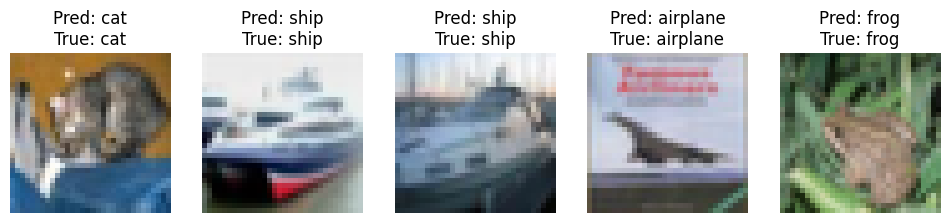

In [21]:
import matplotlib.pyplot as plt

# --- 결과 시각화 ---
plt.figure(figsize=(12, 4))
for i, img in enumerate(sample_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    # 이미지 제목에 예측 결과와 실제 정답 표시
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}")
    plt.axis('off')
plt.show()

 HuggingFace의 pipeline을 사용하면 위 과정을 더 간단하게 처리할 수도 있습니다.

 와 같이 하면 이미지마다 예측된 레이블과 신뢰도(score)를 쉽게 얻을 수 있습니다. pipeline은 내부적으로 feature extractor와 모델 예측 과정을 캡슐화하여 편의성을 제공합니다.

In [22]:
from transformers import pipeline
# 이미지 분류 파이프라인 생성
clf = pipeline("image-classification",
               model=model_name, device=device)

# 문제 12: 파이프라인을 사용하여 예측을 수행하세요
# 파이프라인으로 예측 수행
# [START CODE]
preds = clf(sample_images)
# [END CODE]

print(preds)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda


[[{'label': 'LABEL_3', 'score': 0.9927236437797546}, {'label': 'LABEL_5', 'score': 0.0012952452525496483}, {'label': 'LABEL_9', 'score': 0.0009297925280407071}, {'label': 'LABEL_0', 'score': 0.0008214304689317942}, {'label': 'LABEL_8', 'score': 0.0007351312669925392}], [{'label': 'LABEL_8', 'score': 0.9955234527587891}, {'label': 'LABEL_1', 'score': 0.0007332785753533244}, {'label': 'LABEL_0', 'score': 0.0005330530111677945}, {'label': 'LABEL_2', 'score': 0.0005047415033914149}, {'label': 'LABEL_4', 'score': 0.0005029547610320151}], [{'label': 'LABEL_8', 'score': 0.9930387139320374}, {'label': 'LABEL_1', 'score': 0.002421507379040122}, {'label': 'LABEL_4', 'score': 0.0006866457988508046}, {'label': 'LABEL_9', 'score': 0.0006693332688882947}, {'label': 'LABEL_3', 'score': 0.0006172182620503008}], [{'label': 'LABEL_0', 'score': 0.9931061863899231}, {'label': 'LABEL_2', 'score': 0.0019252653000876307}, {'label': 'LABEL_3', 'score': 0.0007438044995069504}, {'label': 'LABEL_7', 'score': 0.0

In [23]:
from transformers import pipeline
clf = pipeline("image-classification", model=model_name)
preds = clf(sample_images)

# 예측 결과를 더 읽기 쉽게 출력
print("Pipeline 예측 결과:")
for i, pred_list in enumerate(preds):
    print(f"이미지 {i+1}:")
    for pred in pred_list:
        # 'LABEL_X' 문자열에서 레이블 인덱스 추출
        label_index = int(pred['label'].split('_')[1])
        print(f"  - 레이블: {labels[label_index]}, 신뢰도: {pred['score']:.4f}")


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Device set to use cuda:0


Pipeline 예측 결과:
이미지 1:
  - 레이블: cat, 신뢰도: 0.9927
  - 레이블: dog, 신뢰도: 0.0013
  - 레이블: truck, 신뢰도: 0.0009
  - 레이블: airplane, 신뢰도: 0.0008
  - 레이블: ship, 신뢰도: 0.0007
이미지 2:
  - 레이블: ship, 신뢰도: 0.9955
  - 레이블: automobile, 신뢰도: 0.0007
  - 레이블: airplane, 신뢰도: 0.0005
  - 레이블: bird, 신뢰도: 0.0005
  - 레이블: deer, 신뢰도: 0.0005
이미지 3:
  - 레이블: ship, 신뢰도: 0.9930
  - 레이블: automobile, 신뢰도: 0.0024
  - 레이블: deer, 신뢰도: 0.0007
  - 레이블: truck, 신뢰도: 0.0007
  - 레이블: cat, 신뢰도: 0.0006
이미지 4:
  - 레이블: airplane, 신뢰도: 0.9931
  - 레이블: bird, 신뢰도: 0.0019
  - 레이블: cat, 신뢰도: 0.0007
  - 레이블: horse, 신뢰도: 0.0007
  - 레이블: dog, 신뢰도: 0.0007
이미지 5:
  - 레이블: frog, 신뢰도: 0.9954
  - 레이블: automobile, 신뢰도: 0.0006
  - 레이블: airplane, 신뢰도: 0.0006
  - 레이블: ship, 신뢰도: 0.0005
  - 레이블: cat, 신뢰도: 0.0005


# **마치며**


이상으로 CIFAR-10을 활용한 컴퓨터 비전 AI 을 실습해 보았습니다.

섹션 1에서는 ResNet-18 모델의 마지막 층만 학습하는 선형 프로빙으로 빠르게 성능을 얻는 방법을, 섹션 2에서는 데이터 증강과 전체 모델 미세 조정으로 성능을 극대화하는 방법을 배웠으며, 섹션 3에서는 HuggingFace의 사전 학습 ViT 모델을 이용하여 손쉽게 이미지 분류를 수행해 보았습니다. 이러한 접근법들은 실제 컴퓨터 비전 과제에 널리 사용되는 기법들이며, 주어진 예시 코드를 바탕으로 다양한 응용을 시도해볼 수 있을 것입니다.
